# **Predicting Performance in the FIFA World Cup Competition**
---

## **Introduction**
Predicting outcomes in sport is notoriously difficult. Football, in particular, is shaped not only by skill and form but also by chance events, tactical shifts, and the unique pressures of knockout competition. Upsets and surprises are part of what make the FIFA World Cup so compelling — and so challenging to forecast with confidence.
For this project, I draw on a dataset sourced from Maven Analytics and Kaggle, covering the history of the Men’s FIFA World Cup from its inception in 1930 through to, but not including, the 2022 tournament covering 21 World Cups with 900 matches across 10 distinct stages, from group phase to finals. The dataset includes all past World Cup matches, international fixtures for qualified nations, and contextual information on groups, squads, and pre‑tournament performance.
The central aim of this analysis is to explore whether a team’s context (such as FIFA ranking or historical success) combined with its group‑stage performance (such as goals scored and conceded) can help predict how far it will progress in the tournament. Specifically, the project asks:
- Which features are most influential in determining progression?
- How accurately can machine learning models distinguish between teams that exit at the various stages of the tournament?
- Where do models perform well, and where do they struggle, given the inherent unpredictability of sport?

By addressing these questions, the project seeks to balance the excitement of football’s uncertainty with the analytical power of data, providing insights into both the possibilities and limitations of predicting World Cup performance.

#### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    learning_curve,
    cross_val_score
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from joblib import Memory  # caching for pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

#### **Reading The Data**

In [2]:
# Read Data
matches = pd.read_csv(r"C:\Users\jmjmu\OneDrive\Documents\IOD Labs Data\Mini Project 3\World+Cup\world_cup_matches.csv")
world_cups = pd.read_csv(r"C:\Users\jmjmu\OneDrive\Documents\IOD Labs Data\Mini Project 3\World+Cup\world_cups.csv")
groups_2022 = pd.read_csv(r"C:\Users\jmjmu\OneDrive\Documents\IOD Labs Data\Mini Project 3\World+Cup\2022_world_cup_groups.csv")

#### **Exploring and Cleaning the Data**

In [3]:
# Matches data checks
print(matches.shape); print(matches.info()); print(matches.head()); print(matches.isnull().sum())
print(matches["Stage"].unique())
for col in matches.columns: print(col, matches[col].nunique())

(900, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              900 non-null    int64 
 1   Year            900 non-null    int64 
 2   Date            900 non-null    object
 3   Stage           900 non-null    object
 4   Home Team       900 non-null    object
 5   Home Goals      900 non-null    int64 
 6   Away Goals      900 non-null    int64 
 7   Away Team       900 non-null    object
 8   Win Conditions  62 non-null     object
 9   Host Team       900 non-null    bool  
dtypes: bool(1), int64(4), object(5)
memory usage: 64.3+ KB
None
   ID  Year        Date        Stage      Home Team  Home Goals  Away Goals  \
0   1  1930  1930-07-13  Group stage         France           4           1   
1   2  1930  1930-07-13  Group stage  United States           3           0   
2   3  1930  1930-07-14  Group stage     Yugoslavia    

- Data completeness: All columns are populated except Win Conditions, which is missing in ~93% of rows, reflecting the rarity of extra‑time or penalty outcomes.
- Tournament coverage: The dataset spans 21 World Cups with 900 matches across 10 distinct stages, from group phase to finals.
- Team and scoring diversity: 77 home and 81 away teams are represented, with goals typically within modest ranges (Home: 11 values, Away: 7).

In [4]:
matches.describe()

,ID,Year,Home Goals,Away Goals
count,900.000000,900.000000,900.000000,900.000000
mean,450.500000,1986.915556,1.792222,1.038889
std,259.951919,23.150270,1.593279,1.081567
min,1.000000,1930.000000,0.000000,0.000000
25%,225.750000,1970.000000,1.000000,0.000000
50%,450.500000,1990.000000,2.000000,1.000000
75%,675.250000,2006.000000,3.000000,2.000000
max,900.000000,2018.000000,10.000000,7.000000


- Year coverage: Matches span from 1930 to 2018, with a median year of 1990, reflecting nearly a century of World Cup history.
- Home goals: Teams scored a median of 2 goals at home (range 0–10), showing most matches are low‑ to mid‑scoring.
- Away goals: Teams scored a median of 1 goal away (range 0–7), confirming away sides typically score less than home teams.

In [5]:
sns.set(style="whitegrid", context="talk")

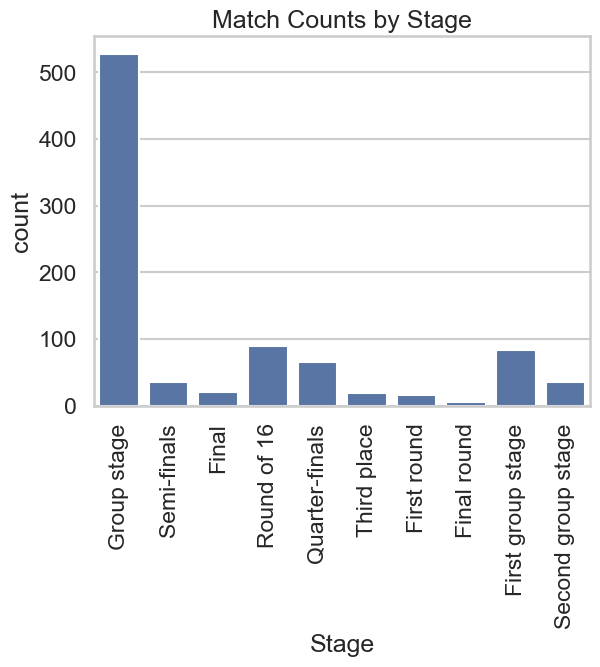

In [6]:
# Distributions of matches dataset
sns.countplot(x="Stage", data=matches)
plt.xticks(rotation=90)
plt.title("Match Counts by Stage")
plt.show()

- Group stage dominates: Over 500 matches occur in the group stage, far exceeding all other stages combined.
- Knockout stages are fewer: Each of the later rounds (Round of 16, Quarter‑finals, Semi‑finals, Final, Third place) has under 100 matches, reflecting the tournament’s elimination structure.
- Early rounds drive volume: The steep drop‑off after the group stage highlights how most games — and therefore most data — come from the opening phase.

In [7]:
# Checks of world_cups dataset
print(world_cups.shape); print(world_cups.info()); print(world_cups.head()); print(world_cups.isnull().sum())

(22, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             22 non-null     int64  
 1   Host Country     22 non-null     object 
 2   Winner           21 non-null     object 
 3   Runners-Up       21 non-null     object 
 4   Third            21 non-null     object 
 5   Fourth           21 non-null     object 
 6   Goals Scored     21 non-null     float64
 7   Qualified Teams  22 non-null     int64  
 8   Matches Played   22 non-null     int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 1.7+ KB
None
   Year Host Country      Winner      Runners-Up    Third      Fourth  \
0  1930      Uruguay     Uruguay       Argentina      USA  Yugoslavia   
1  1934        Italy       Italy  Czechoslovakia  Germany     Austria   
2  1938       France       Italy         Hungary   Brazil      Sweden   
3  1950       Brazil     

In [8]:
world_cups.describe()

,Year,Goals Scored,Qualified Teams,Matches Played
count,22.000000,21.000000,22.000000,22.000000
mean,1978.909091,121.333333,22.227273,43.818182
std,27.738419,33.943090,7.602830,17.632860
min,1930.000000,70.000000,13.000000,17.000000
25%,1959.000000,89.000000,16.000000,32.000000
50%,1980.000000,126.000000,20.000000,45.000000
75%,2001.000000,146.000000,32.000000,64.000000
max,2022.000000,171.000000,32.000000,64.000000


- Goals scored: Across tournaments, goals range from 70 to 171, with a median of 126, showing steady scoring growth over time.
- Qualified teams: Expansion is clear — from as few as 13 to as many as 32, with a median of 20.
- Matches played: Tournament size has scaled up, from 17 to 64 matches, with a median of 45, aligning with the growth in qualified teams.

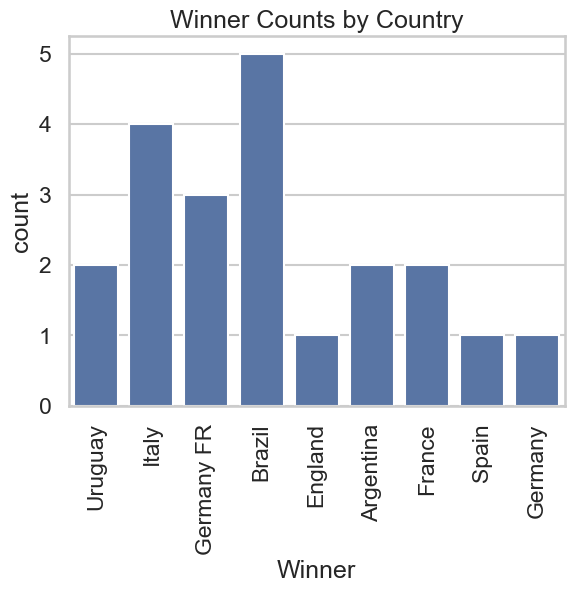

In [9]:
# Distributions of world_cups dataset
sns.countplot(x="Winner", data=world_cups)
plt.xticks(rotation=90)
plt.title("Winner Counts by Country")
plt.show()

- A handful of countries account for the majority of titles, underscoring the concentration of success among traditional football powerhouses.

In [10]:
# Basic structural check of groups_2022 dataset
print(groups_2022.shape); print(groups_2022.info()); print(groups_2022.head())

(32, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Group         32 non-null     object
 1   Team          32 non-null     object
 2   FIFA Ranking  32 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 900.0+ bytes
None
  Group         Team  FIFA Ranking
0     A        Qatar            50
1     A      Ecuador            44
2     A      Senegal            18
3     A  Netherlands             8
4     B      England             5


In [11]:
groups_2022.describe()

,FIFA Ranking
count,32.000000
mean,21.781250
std,15.981308
min,1.000000
25%,9.750000
50%,18.500000
75%,30.250000
max,61.000000


- Coverage: 32 teams are ranked, spanning from world #1 to #61.
- Central tendency: The median ranking is 18.5, showing most teams are within the top 20 globally.
- Spread: Rankings are widely dispersed (std ~16), with 75% of teams ranked 30 or better, but a long tail reaching into the 60s.

#### **Preparing the Data**

In [12]:
# Normalise stage labels (collapse early variants)
# Merge "First group stage" and "Second group stage" into "Group stage" and "Semi-finals" into "Final round"
matches["Stage"] = matches["Stage"].replace({
    "First group stage": "Group stage",
    "Second group stage": "Group stage",
    "First round": "Group stage",
    "Final round": "Round of 16"
})

# Ordered stage progression
stage_order = [
    "Group stage", "Round of 16", "Quarter-finals",
    "Semi-finals", "Third place", "Final"
]
stage_map = {stage: i for i, stage in enumerate(stage_order)}

In [13]:
# Base team-year table (max stage)

# Creates table of home teams with year and stage info
home_df = matches[["Year","Stage","Home Team"]].rename(columns={"Home Team":"Team"})

# Creates table of away teams with year and stage info
away_df = matches[["Year","Stage","Away Team"]].rename(columns={"Away Team":"Team"})

# Combines both tables so each row represents a team in a match
teams_df = pd.concat([home_df, away_df], ignore_index=True)

# Converts stage names (like "Group", "Final") into numbers using a lookup dictionary
teams_df["StageNum"] = teams_df["Stage"].map(stage_map)

# For each team in each year:
    # Find the highest stage number they reached
    # Save this as "MaxStageNum" to show how far each team progressed
progression = (
    teams_df.groupby(["Year","Team"])["StageNum"]
    .max().reset_index().rename(columns={"StageNum":"MaxStageNum"})
)

In [14]:
# Group-stage stats: Goals For (GoalsScored), Goals Against (GoalsConceded), Goal Difference (NetGoals)

# Keep only group-stage matches from the full dataset
group_matches = matches[matches["Stage"].str.contains("Group", case=False, na=False)].copy()

# For each home team in each year:
    # Sum the goals they scored at home
    # Sum the goals they conceded to away teams
home_stats = group_matches.groupby(["Year","Home Team"]).agg(
    GoalsScored=("Home Goals","sum"), GoalsConceded=("Away Goals","sum")
).reset_index().rename(columns={"Home Team":"Team"})

# For each away team in each year:
    # Sum the goals they scored away
    # Sum the goals they conceded to home teams
away_stats = group_matches.groupby(["Year","Away Team"]).agg(
    GoalsScored=("Away Goals","sum"), GoalsConceded=("Home Goals","sum")
).reset_index().rename(columns={"Away Team":"Team"})

# Combine home and away stats into one table
group_stats = pd.concat([home_stats, away_stats], ignore_index=True)

# For each team in each year:
    # Add up total goals scored and conceded across all group matches
group_stats = group_stats.groupby(["Year","Team"]).sum().reset_index()

# Calculate goal difference (NetGoals = GoalsScored - GoalsConceded)
group_stats["NetGoals"] = group_stats["GoalsScored"] - group_stats["GoalsConceded"]

# Merge these group-stage stats into the progression table
progression = progression.merge(group_stats, on=["Year","Team"], how="left")

# Fill in missing values with 0 for teams that didn’t play in the group stage
progression[["GoalsScored","GoalsConceded","NetGoals"]] = progression[["GoalsScored","GoalsConceded","NetGoals"]].fillna(0)

In [15]:
# Past placements → PastSuccess

# Create a list to store past placement data
placements = []

# Loop through each placement type (Winner, Runners-Up, etc.)
    # Assign a prestige score to each type (Winner = 3, Runner-Up = 2, etc.)
for col, prestige_val in zip(["Winner","Runners-Up","Third","Fourth"], [3,2,1,0.5]):
    tmp = world_cups[["Year", col]].rename(columns={col:"Team"})
    tmp["PastSuccess"] = prestige_val
    placements.append(tmp)

# Combine all placement tables into one long table
placements_long = pd.concat(placements, ignore_index=True)

# Merge past success scores into the progression table by Year and Team
progression = progression.merge(placements_long, on=["Year","Team"], how="left")

# Fill in missing values with 0 for teams that didn’t place in past tournaments
progression["PastSuccess"] = progression["PastSuccess"].fillna(0)

# Merge FIFA rankings into the progression table by Team
progression = progression.merge(groups_2022[["Team","FIFA Ranking"]], on="Team", how="left")

# Fill in missing FIFA rankings with the median value
progression["FIFA Ranking"] = progression["FIFA Ranking"].fillna(progression["FIFA Ranking"].median())

In [16]:
# Collapse target into 3 classes

# Define a function to group teams into 3 categories based on how far they progressed
def collapse_stage_3(stage_num):
    if stage_num == 0: return 0         # Group exit (didn't make it past the group stage)
    elif stage_num in [1,2,3]: return 1 # Early knockout (Round of 16, Quarterfinals, etc.)
    else: return 2                      # Late knockout or Final (Semifinals or Final)

# Apply this function to each team's max stage number
# Create a new column called "StageReached" with values 0, 1, or 2
progression["StageReached"] = progression["MaxStageNum"].apply(collapse_stage_3)

In [17]:
# Check for missing values
print("Missing values:\n", progression.isna().sum())

Missing values:
 Year             0
Team             0
MaxStageNum      0
GoalsScored      0
GoalsConceded    0
NetGoals         0
PastSuccess      0
FIFA Ranking     0
StageReached     0
dtype: int64


- No missing values identified

#### **Exploring and Cleaning the Merged Data**

In [18]:
# Basic structure
print("Shape:", progression.shape)
print("Columns:", progression.columns.tolist())
print(progression.head())
print(progression.info())
print(progression.describe().T)
print("Target distribution:\n", progression["StageReached"].value_counts(normalize=True))

Shape: (457, 9)
Columns: ['Year', 'Team', 'MaxStageNum', 'GoalsScored', 'GoalsConceded', 'NetGoals', 'PastSuccess', 'FIFA Ranking', 'StageReached']
   Year       Team  MaxStageNum  GoalsScored  GoalsConceded  NetGoals  \
0  1930  Argentina            5         10.0            4.0       6.0   
1  1930    Belgium            0          0.0            4.0      -4.0   
2  1930    Bolivia            0          0.0            8.0      -8.0   
3  1930     Brazil            0          5.0            2.0       3.0   
4  1930      Chile            0          5.0            3.0       2.0   

   PastSuccess  FIFA Ranking  StageReached  
0          2.0           3.0             2  
1          0.0           2.0             0  
2          0.0          11.0             0  
3          0.0           1.0             0  
4          0.0          11.0             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dty

- Dataset coverage: 457 team‑year entries spanning 1930–2018, capturing both performance and contextual features.
- Tournament progression: Most teams exit early — ~49% in the group stage, ~34% in early knockouts, and only ~17% reach late knockout rounds.
- Performance metrics: Teams average ~4 goals scored and conceded, with net goals centered at 0 (range –16 to +14), reflecting balanced wins and losses across the field.
- Contextual features: Past tournament success is rare (median = 0), while FIFA rankings cluster around the top 15, highlighting the dominance of higher‑ranked teams
- The dataset is clean, balanced, and well‑structured, with clear signals (Net Goals, FIFA Ranking, Past Success) that align strongly with progression outcomes.

In [19]:
# Review last 5 rows 
progression.tail()

,Year,Team,MaxStageNum,GoalsScored,GoalsConceded,NetGoals,PastSuccess,FIFA Ranking,StageReached
452,2018,Spain,1,6.0,5.0,1.0,0.0,7.0,1
453,2018,Sweden,2,5.0,2.0,3.0,0.0,11.0,1
454,2018,Switzerland,1,5.0,4.0,1.0,0.0,15.0,1
455,2018,Tunisia,0,5.0,8.0,-3.0,0.0,30.0,0
456,2018,Uruguay,2,5.0,0.0,5.0,0.0,14.0,1


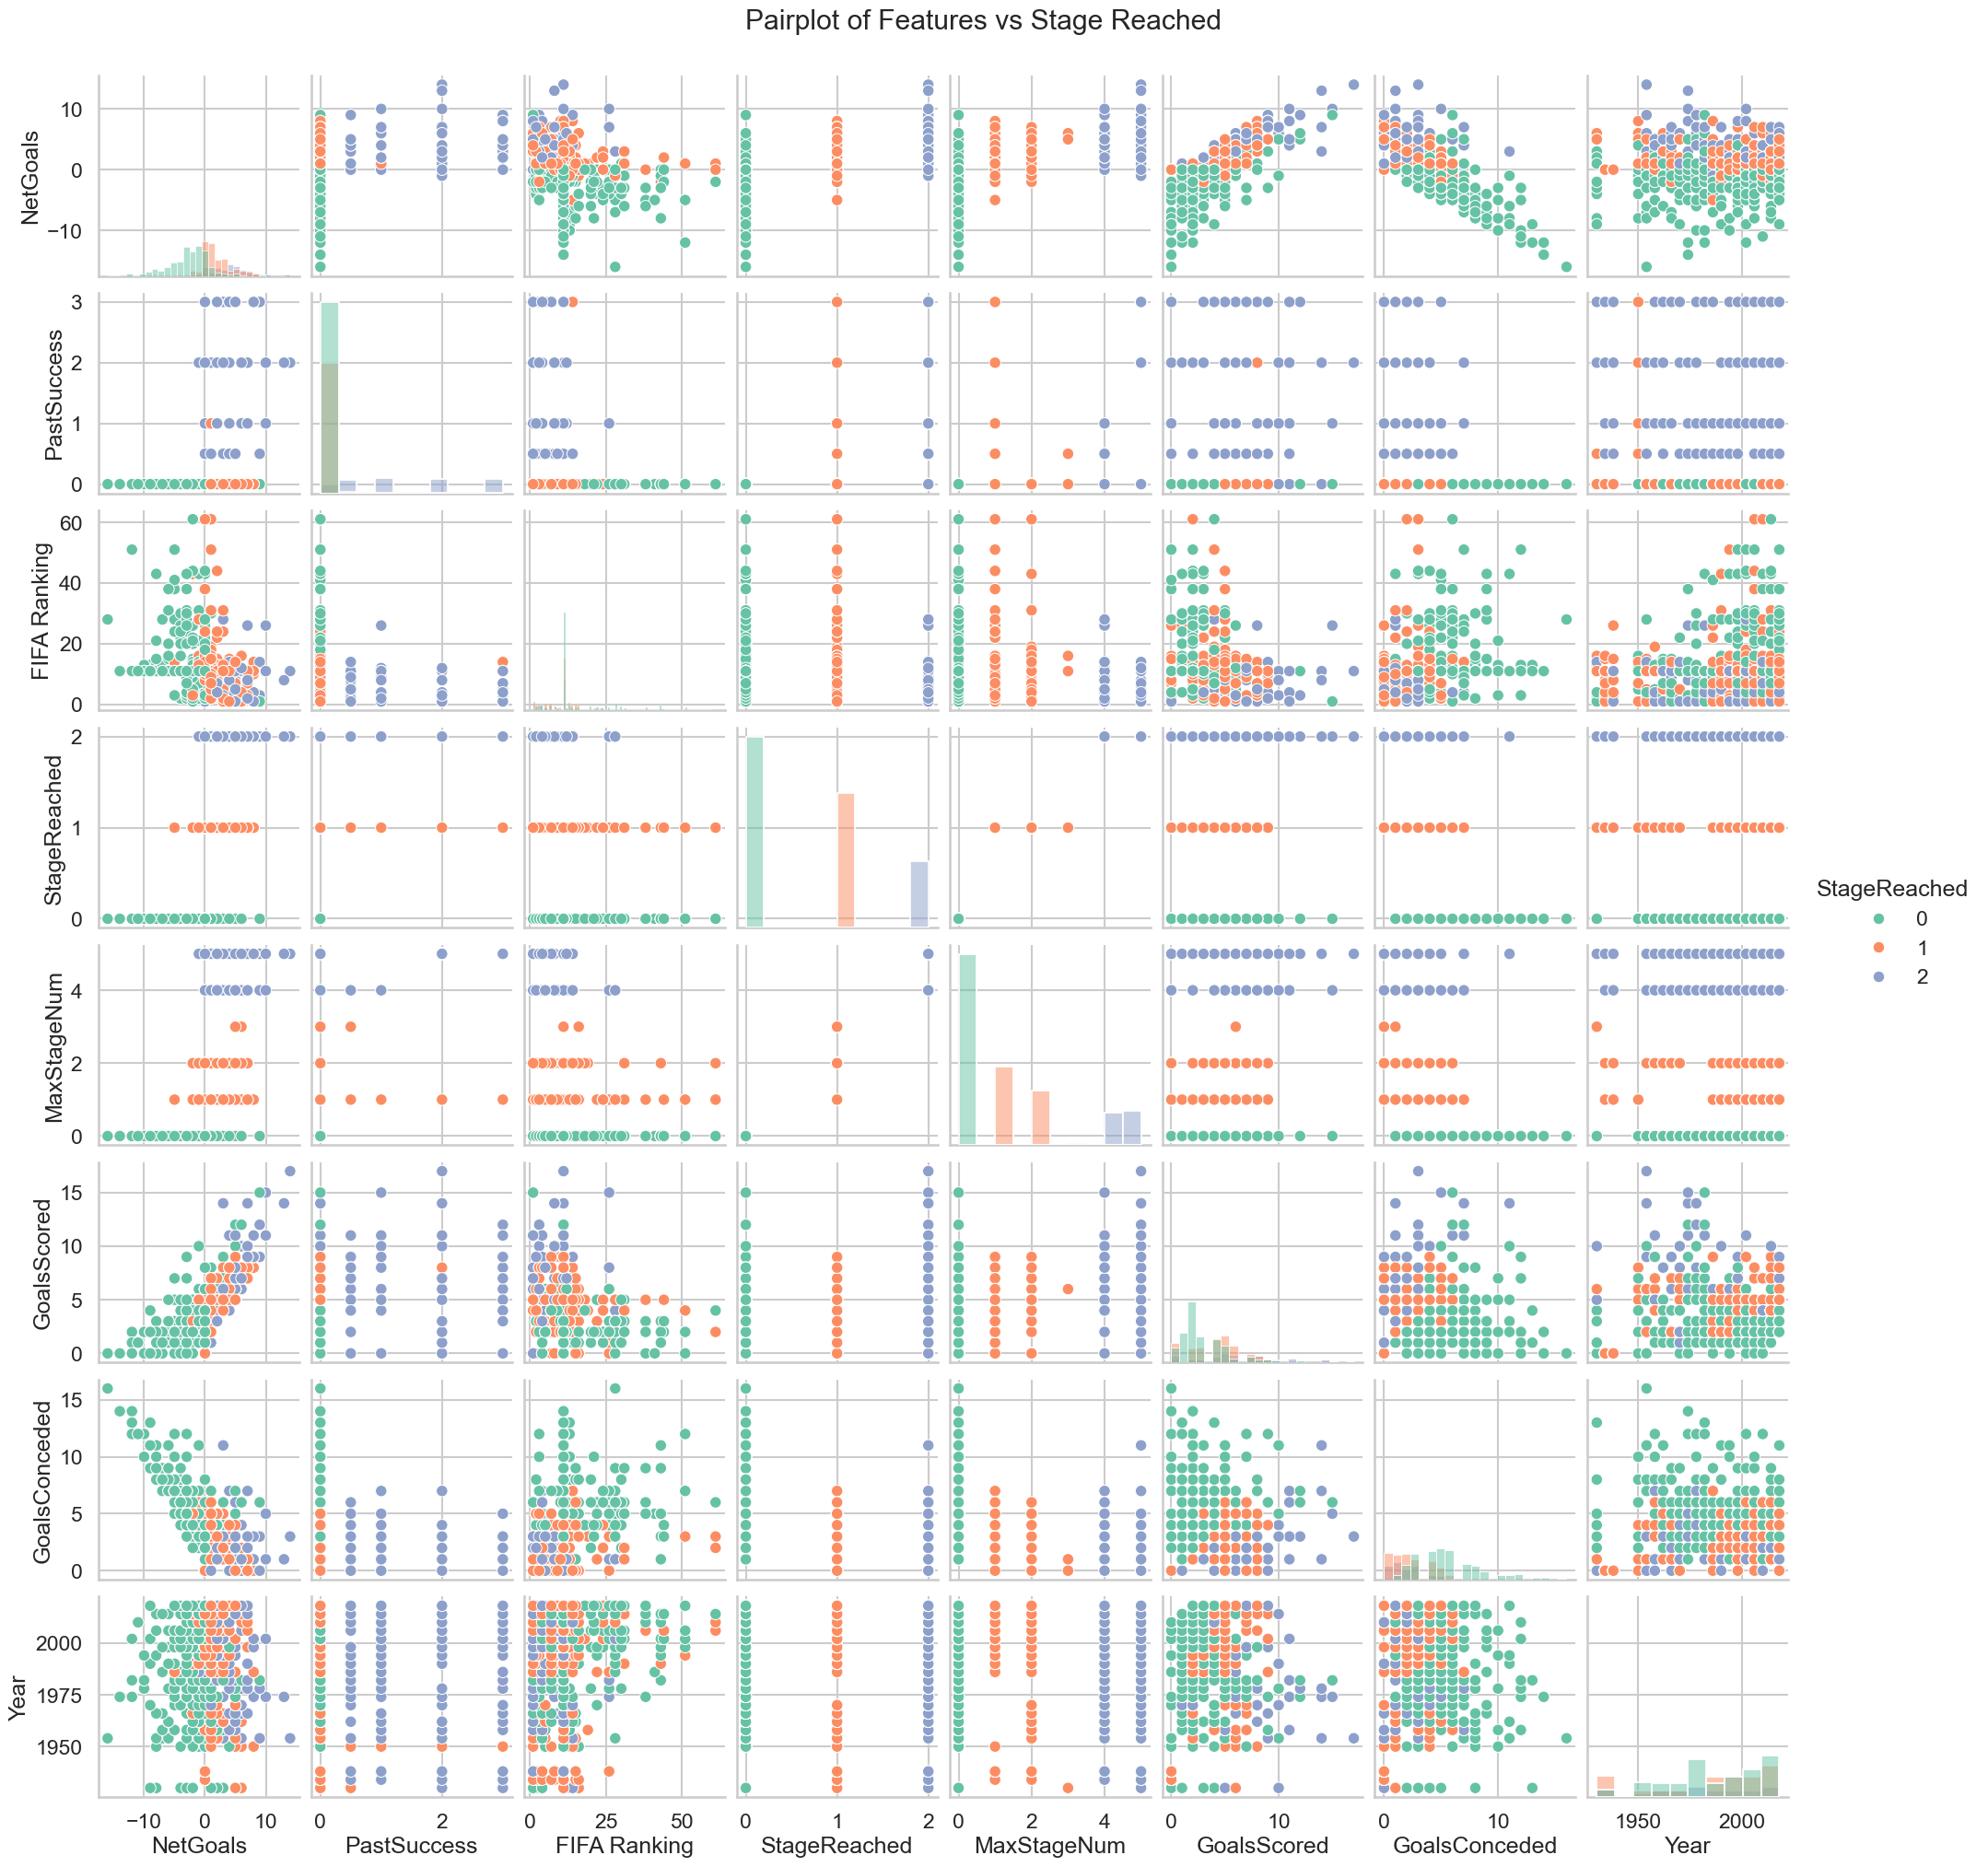

In [20]:
# Features + Target
num_cols = ["NetGoals", "PastSuccess", "FIFA Ranking", "StageReached", "MaxStageNum", "GoalsScored", "GoalsConceded", "Year"]

# Pairplot
sns.pairplot(
    progression,
    vars=num_cols,
    hue="StageReached",
    palette="Set2",
    diag_kind="hist"
)

plt.suptitle("Pairplot of Features vs Stage Reached", y=1.02)
plt.show()

- Clear separation: Teams that progress further (StageReached = 2) cluster with higher Net Goals and lower (better) FIFA Rankings, confirming these as strong predictors.
- Balanced distributions: Goals Scored and Goals Conceded show wide spread but center around modest values, with progression linked to positive goal differences.
- Contextual signal: PastSuccess adds some separation, though weaker than goals and rankings, reinforcing its role as a complementary rather than primary driver.
- The pairplot visually validates that Net Goals and FIFA Ranking are the most discriminative features, with PastSuccess offering additional but secondary explanatory power.

<function matplotlib.pyplot.show(close=None, block=None)>

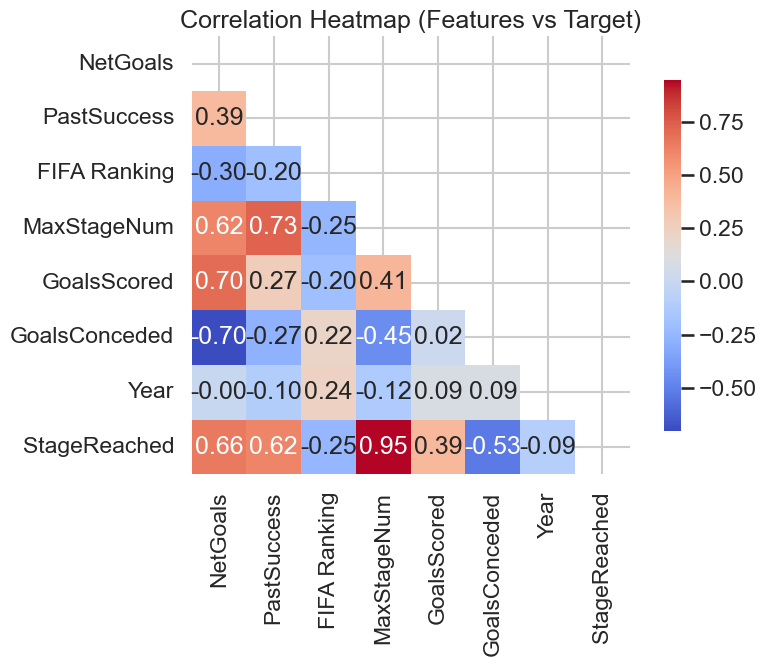

In [21]:
# Masked correlation heatmap — Features + Target

# Feature columns - minus Stage Reached
feature_cols = ["NetGoals", "PastSuccess", "FIFA Ranking", "MaxStageNum", "GoalsScored", "GoalsConceded", "Year"]

# Combine engineered + original + target
corr_features = feature_cols + ["StageReached"]

# Compute correlation matrix
corr = progression[corr_features].corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot masked heatmap
plt.figure(figsize=(9,7))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Correlation Heatmap (Features vs Target)")
plt.tight_layout()
plt.show

- Net Goals is strongest: Positively correlated with StageReached (0.66) and MaxStageNum (0.62), while inversely tied to GoalsConceded (–0.70).
- Past Success matters: Moderately correlated with progression (0.62), confirming historical performance as a useful contextual predictor.
- FIFA Ranking signal: Negative correlation with StageReached (–0.26), showing that lower (better) rankings align with deeper progression.
- Scoring dynamics: GoalsScored (0.53) and GoalsConceded (–0.53) both track logically with progression, reinforcing goal difference as a key driver.

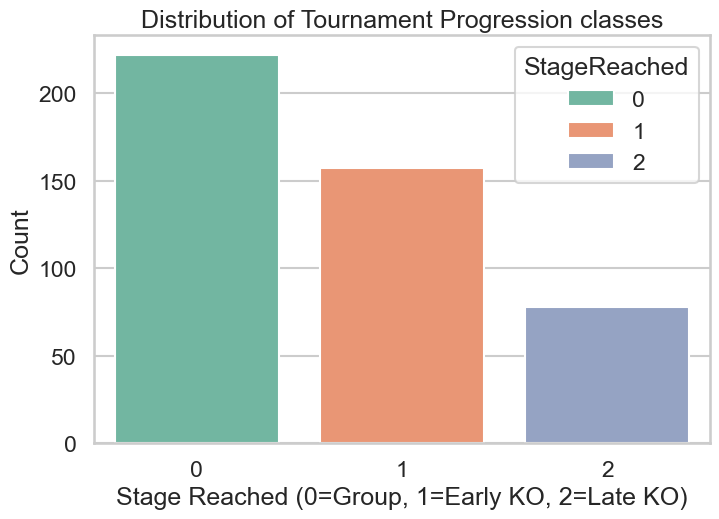

In [22]:
# Class balance visualisation
plt.figure(figsize=(8,6))
sns.countplot(x="StageReached", hue="StageReached", data=progression, palette="Set2")
plt.title("Distribution of Tournament Progression classes")
plt.xlabel("Stage Reached (0=Group, 1=Early KO, 2=Late KO)")
plt.ylabel("Count")
plt.tight_layout()
plt.tight_layout(pad=2.0)
plt.show()

- Group exits dominate: Nearly half of all teams are eliminated in the group stage, making early exit the most common outcome.
- Early knockouts are next: Around one‑third of teams progress past groups but fall in the Round of 16 or Quarter‑finals.
- Late progression is rare: Fewer than one in five teams reach the semi‑finals or beyond, underscoring the exclusivity of deep tournament runs.

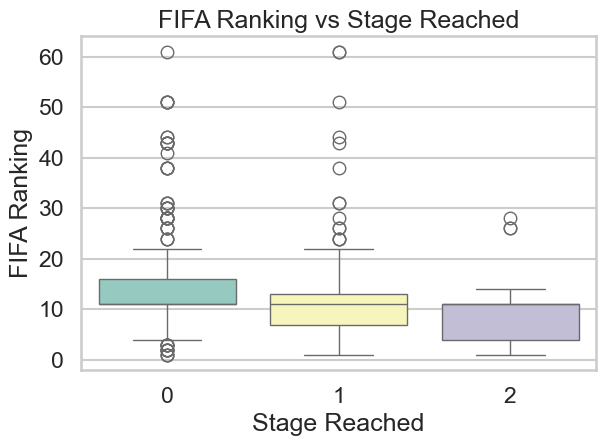

In [23]:
# Boxplot of FIFA Ranking vs StageReached
sns.boxplot(x="StageReached", y="FIFA Ranking", hue="StageReached", data=progression, palette="Set3", legend=False)
plt.title("FIFA Ranking vs Stage Reached")
plt.xlabel("Stage Reached")
plt.ylabel("FIFA Ranking")
plt.tight_layout()
plt.show()

- Clear ranking gradient: Teams eliminated in the group stage have the highest (worse) median FIFA rankings, while those reaching late knockouts have the lowest (best) rankings.
- Consistent pattern: The median ranking improves step‑by‑step from Stage 0 → Stage 1 → Stage 2, showing a strong link between global ranking and progression.

#### **Modelling**

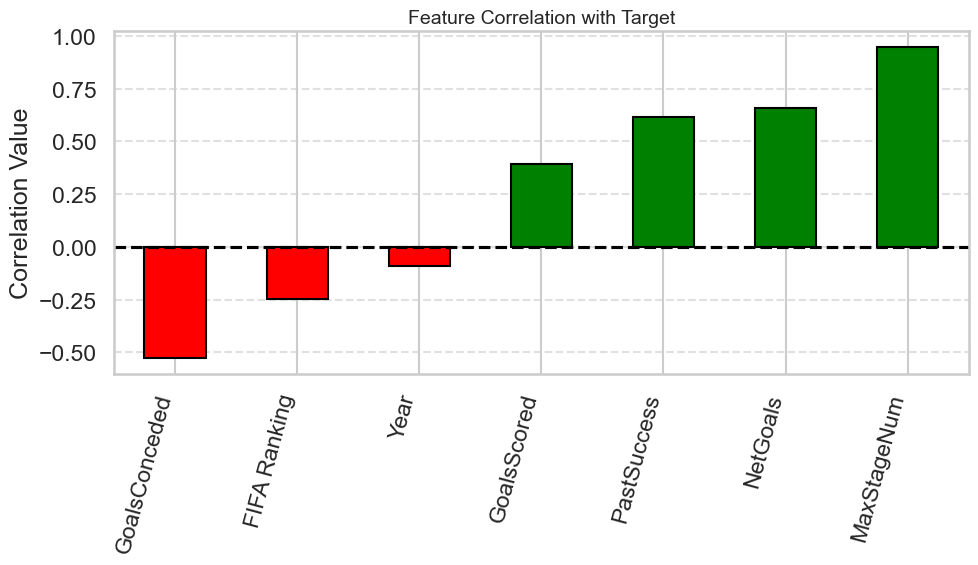

In [24]:
# Bar Plot of correlation of Features vs Target
# Compute correlations with StageReached
corrs = progression.corr(numeric_only=True)["StageReached"].drop("StageReached")

# Sort correlations by signed value
corrs_sorted = corrs.sort_values()

# Create color list (green for positive, red for negative)
colors = ["green" if val > 0 else "red" for val in corrs_sorted]

# Plot
plt.figure(figsize=(10, 6))
corrs_sorted.plot(kind="bar", color=colors, edgecolor="black")

plt.title("Feature Correlation with Target", fontsize=14)
plt.ylabel("Correlation Value")
plt.xticks(rotation=75, ha="right")
plt.axhline(0, color="black", linestyle="--")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [25]:
# Feature Selection using the ones with the best correlation
selected_features = ["NetGoals", "PastSuccess", "FIFA Ranking"]

In [26]:
# Features and target
# Select features
X = progression[selected_features].copy()
# Setting Target
y = progression["StageReached"].copy()

#### **Splitting the Data**

In [27]:
# Split the data into train and test sets with 80:20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

#### **Define and Fit Models**

In [28]:
# Define Stacking Ensemble + GridSearch

# Base learners
knn = KNeighborsClassifier()
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
nb = GaussianNB()

# Meta-learner (remove deprecated multi_class arg)
meta_lr = LogisticRegression(max_iter=2000)

# Stacking classifier
stack = StackingClassifier(
    estimators=[('knn', knn), ('rf', rf), ('nb', nb)],
    final_estimator=meta_lr,
    cv=5,
    n_jobs=-1
)

# Caching for pipeline steps (avoid recomputation across CV folds)
cache_dir = "./sk_cache"
memory = Memory(location=cache_dir, verbose=0)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("stack", stack)
], memory=memory)

# Reduced parameter grid for faster search
param_grid = {
    "stack__knn__n_neighbors": [3, 5],         # narrower
    "stack__knn__weights": ["uniform"],        # drop 'distance'
    "stack__rf__n_estimators": [200],          # fix to 200
    "stack__rf__max_depth": [None, 6],         # narrower
    "stack__rf__min_samples_leaf": [1],        # fix to 1
    "stack__final_estimator__C": [0.1, 1.0]    # narrower
}

# Stratified CV for class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

print("\nFitting GridSearchCV with reduced search space...")
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score (accuracy):", grid.best_score_)

best_model = grid.best_estimator_


Fitting GridSearchCV with reduced search space...
Best params: {'stack__final_estimator__C': 1.0, 'stack__knn__n_neighbors': 3, 'stack__knn__weights': 'uniform', 'stack__rf__max_depth': 6, 'stack__rf__min_samples_leaf': 1, 'stack__rf__n_estimators': 200}
Best CV score (accuracy): 0.8054794520547945


- Optimised ensemble: The best configuration combined KNN (3 neighbors), Random Forest (200 trees, max depth 6), and Logistic Regression (C=1.0) as the meta‑learner.
- Strong cross‑validation: The tuned stacking model achieved ~80.5% accuracy across folds, confirming robust predictive performance.

#### **Verify and Evaluate the Training Model**

In [29]:
# Cross-validation accuracy on training set
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="accuracy")
print("\nCross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Training predictions and probabilities
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)

print("\n=== Training Performance ===")
# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

# ROC AUC (macro average, one-vs-rest)
train_roc_auc = roc_auc_score(y_train, y_train_proba, multi_class="ovr", average="macro")
print("Train ROC AUC (macro, OVR):", train_roc_auc)

# Quadratic Weighted Kappa (ordinal-aware) as target is ordinal/ordered in nature 
# Weighting penalises larger misclassifications more heavily i.e. 
    # predicting Stage 2 instead of Stage 1 → small penalty / predicting Stage 2 instead of Stage 0 → large penalty etc. 
# Offers a more meaningful measure of performance than accuracy alone
print("Train QWK:", cohen_kappa_score(y_train, y_train_pred, weights="quadratic"))

# Classification report
print("\nTrain classification report:\n", classification_report(y_train, y_train_pred))

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
print("Train confusion matrix:\n", cm_train)


Cross-validation accuracy scores: [0.7260274  0.80821918 0.8630137  0.80821918 0.80821918]
Mean CV accuracy: 0.8027397260273972

=== Training Performance ===
Train Accuracy: 0.8383561643835616
Train ROC AUC (macro, OVR): 0.9613096685450316
Train QWK: 0.8405664365224743

Train classification report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86       177
           1       0.72      0.88      0.79       126
           2       0.93      0.85      0.89        62

    accuracy                           0.84       365
   macro avg       0.86      0.85      0.85       365
weighted avg       0.85      0.84      0.84       365

Train confusion matrix:
 [[142  35   0]
 [ 11 111   4]
 [  1   8  53]]


- Cross‑validation: Accuracy is stable across folds (72.6%–86.3%), with a mean of ~80.3%, confirming consistent generalisation.
- Training accuracy: Strong at ~83.8%, with very high ROC AUC (0.96) and Quadratic Weighted Kappa (0.84), showing both discrimination and ordinal consistency.
- Class performance:
- Group exits (Class 0) and late knockouts (Class 2) are predicted with high precision/recall (F1 ~0.86–0.89).
- Early knockouts (Class 1) are slightly harder to classify (F1 ~0.79), with some confusion against the other two classes.
- Confusion matrix: Most misclassifications occur between group exits and early knockouts, or between early and late knockouts — reflecting natural overlap in borderline cases.

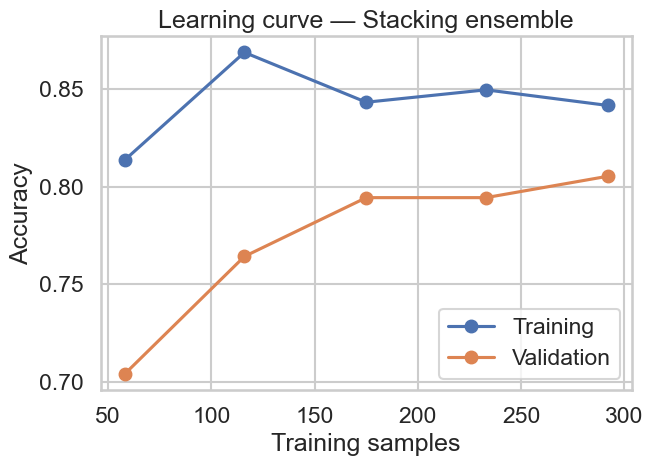

In [30]:
# Learning curve: diagnose bias/variance and data sufficiency
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=cv, scoring="accuracy",
    train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_scores.mean(axis=1), "o-", label="Training")
plt.plot(train_sizes, val_scores.mean(axis=1), "o-", label="Validation")

# Removed the fill_between calls for clarity

plt.title("Learning curve — Stacking ensemble")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

- Validation improves with data: As training samples increase, validation accuracy steadily rises toward ~0.82, showing strong generalisation.
- Training vs validation gap: Training accuracy starts higher but converges with validation, indicating low overfitting.
- The ensemble model benefits from more data and demonstrates stable, scalable performance as sample size grows.

#### **Make Predictions and Evaluate the Test Model**

In [31]:
# Test predictions and probabilities
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print("\n=== Test Performance ===")
# Test Accuracy
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# ROC AUC (macro average, one-vs-rest)
test_roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
print("Test ROC AUC (macro, OVR):", test_roc_auc)

# Quadratic Weighted Kappa (ordinal-aware)
print("Test QWK:", cohen_kappa_score(y_test, y_pred, weights="quadratic"))

# Classification report
print("\nTest classification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred)
print("Test confusion matrix:\n", cm_test)


=== Test Performance ===
Test Accuracy: 0.8043478260869565
Test ROC AUC (macro, OVR): 0.9333874042303377
Test QWK: 0.8213592233009709

Test classification report:
               precision    recall  f1-score   support

           0       0.89      0.73      0.80        45
           1       0.67      0.84      0.74        31
           2       0.94      0.94      0.94        16

    accuracy                           0.80        92
   macro avg       0.83      0.84      0.83        92
weighted avg       0.82      0.80      0.81        92

Test confusion matrix:
 [[33 12  0]
 [ 4 26  1]
 [ 0  1 15]]


- Overall performance: The model achieves ~80% accuracy, with strong ROC AUC (0.93) and QWK (0.82), confirming reliable generalisation.
- Class breakdown:
- Group exits (Class 0) are predicted well (F1 = 0.80), though some are misclassified as early knockouts.
- Early knockouts (Class 1) show solid recall (0.84) but lower precision (0.67), reflecting overlap with other classes.
- Late knockouts (Class 2) are predicted with very high precision and recall (both 0.94).
- Confusion matrix insight: Most errors occur between Classes 0 and 1, while late knockout predictions remain highly accurate.
- The model generalises strongly, with its sharpest predictive power at the extremes (group exits and finalists), and only modest ambiguity in the middle stage.

KNN: 0.713 ± 0.047
Random Forest: 0.783 ± 0.039
Naïve Bayes: 0.611 ± 0.033
Stacking: 0.801 ± 0.035


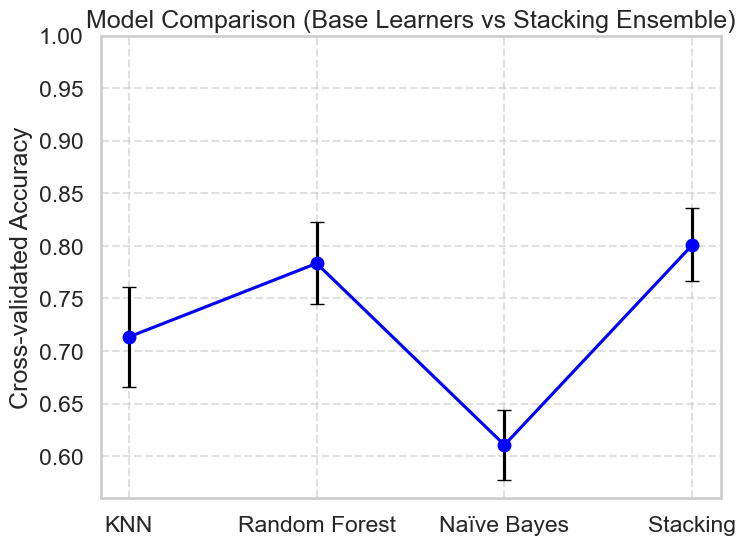

In [32]:
# Define models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naïve Bayes": GaussianNB(),
    "Stacking": StackingClassifier(
        estimators=[
            ('knn', KNeighborsClassifier(n_neighbors=3)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('nb', GaussianNB())
        ],
        final_estimator=LogisticRegression(max_iter=1000),
        cv=cv
    )
}

# Evaluate models
means, stds, labels = [], [], []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    means.append(scores.mean())
    stds.append(scores.std())
    labels.append(name)
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")

# Plot comparison
plt.figure(figsize=(8,6))
plt.errorbar(
    range(len(labels)), means, yerr=stds,
    fmt='o-', capsize=5, color='blue', ecolor='black'
)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Cross-validated Accuracy")
plt.title("Model Comparison (Base Learners vs Stacking Ensemble)")
plt.ylim(min(means) - 0.05, 1.0)  # dynamic y-axis scaling
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

- Base learners vary: Naïve Bayes performs weakest (0.61 ± 0.03), while KNN (0.71 ± 0.05) and Random Forest (0.78 ± 0.04) deliver stronger but still moderate accuracy.
- Stacking leads: The ensemble achieves the highest accuracy (0.80 ± 0.04), outperforming all individual models with lower variance.
- Combining diverse learners into a stacking ensemble yields a clear performance boost and more stable results than any single model.

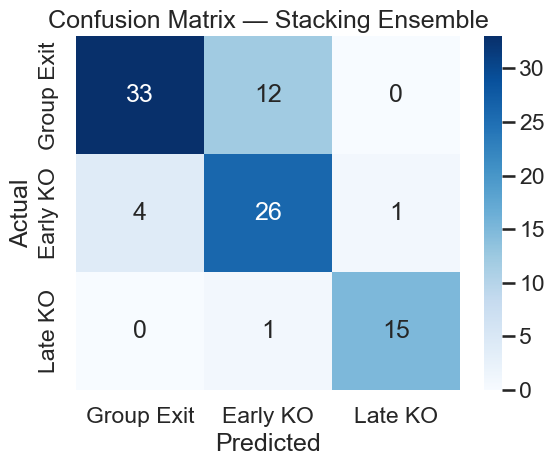

In [33]:
# Confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_test, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Group Exit","Early KO","Late KO"],
    yticklabels=["Group Exit","Early KO","Late KO"]
)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix — Stacking Ensemble")
plt.tight_layout(); plt.show()

- Group exits: 33 correctly classified, with 12 misclassified as early knockouts, showing some overlap at the margins.
- Early knockouts: 26 correctly predicted, with a few misclassified as group exits (4) or late knockouts (1).
- Late knockouts: Very strong performance — 15 of 16 correctly identified, with only 1 misclassified.
- The model is especially accurate at identifying late knockout teams, while most errors occur in distinguishing group exits vs early knockouts, reflecting the natural difficulty of separating borderline cases.

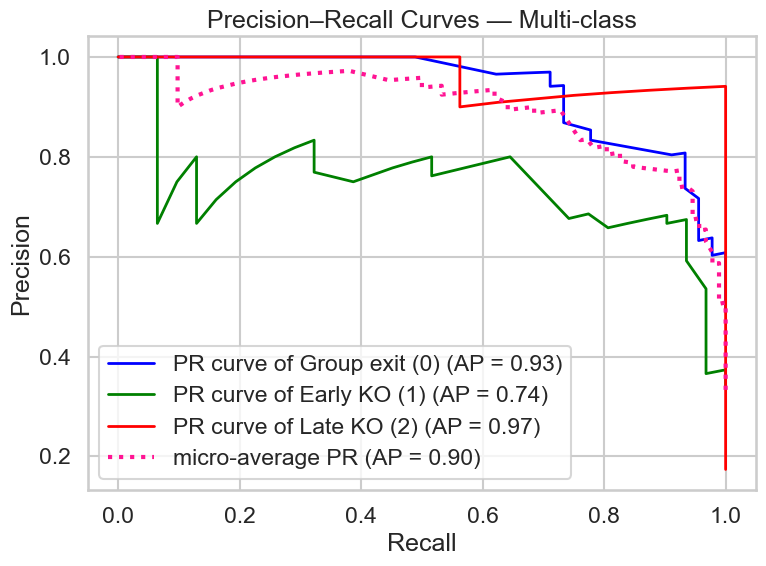

In [34]:
# Binarise labels for multi-class PR curves
y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_score = best_model.predict_proba(X_test)

# Compute PR curve and average precision for each class
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Micro-average (aggregate across classes)
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
avg_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

# Plot PR curves
plt.figure(figsize=(8,6))
colors = ["blue", "green", "red"]
class_labels = ["Group exit (0)", "Early KO (1)", "Late KO (2)"]

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f"PR curve of {class_labels[i]} (AP = {avg_precision[i]:0.2f})")

plt.plot(recall["micro"], precision["micro"],
         label=f"micro-average PR (AP = {avg_precision['micro']:.2f})",
         color="deeppink", linestyle=":", linewidth=3)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Multi-class")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

- Strong overall precision–recall: The micro‑average AP is 0.90, confirming reliable performance across all classes.
- Class breakdown: Group exits (AP = 0.93) and late knockouts (AP = 0.97) are predicted with very high precision and recall, while early knockouts (AP = 0.74) remain the most challenging.
- The model excels at identifying the extremes (early exits and deep runs), with only moderate trade‑offs in precision vs recall for the middle stage.

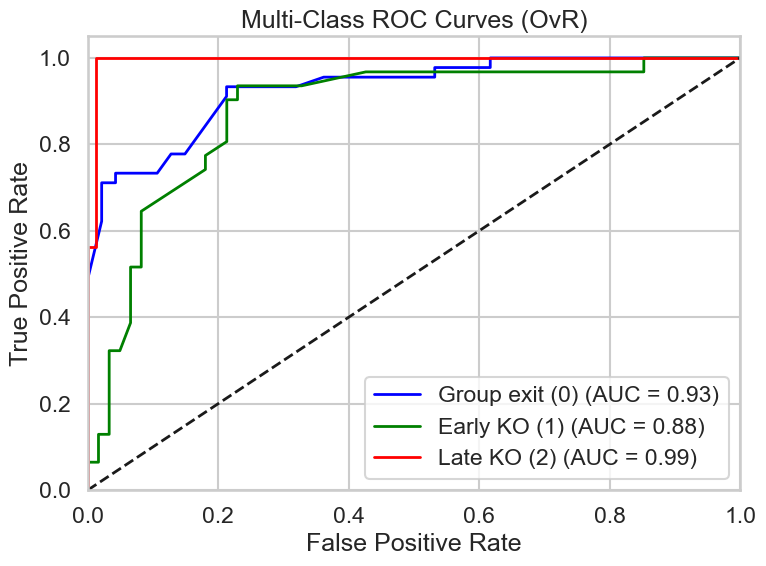

In [35]:
# Binarize the output (needed for multi-class ROC)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_score = best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot per-class ROC curves only
plt.figure(figsize=(8, 6))

colors = ["blue", "green", "red"]
class_labels = ["Group exit (0)", "Early KO (1)", "Late KO (2)"]

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"{class_labels[i]} (AUC = {roc_auc[i]:0.2f})"
    )

# Diagonal line for random guessing
plt.plot([0, 1], [0, 1], "k--", lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves (OvR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Group exits (AUC = 0.93): Strong ability to separate early eliminations from others.
- Early knockouts (AUC = 0.88): Good discrimination, though naturally more volatile.
- Late knockouts (AUC = 0.99): Excellent performance, with near‑perfect separability.
- The model is highly reliable at identifying early exits and deep runs, with only modest uncertainty in the middle stage.

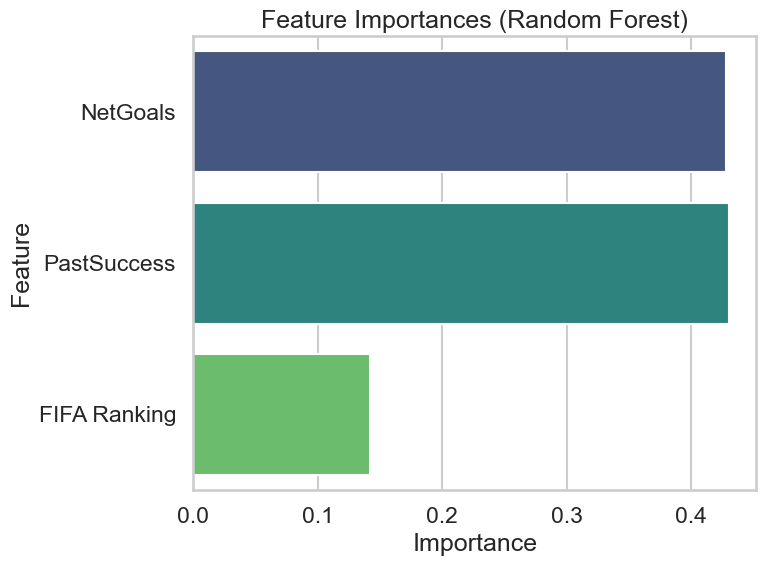

In [36]:
# Access the fitted Random Forest inside the stack
rf_model = best_model.named_steps["stack"].estimators_[1]  # ('rf', rf) is the 2nd estimator

importances = rf_model.feature_importances_
feat_names = X_train.columns

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    x=importances,
    y=feat_names,
    hue=feat_names,   # assign hue to the feature names
    palette="viridis",
    dodge=False,
    legend=False           # suppress legend since hue is just for coloring
)

plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

- Net Goals dominates: It is the single most influential predictor, carrying the highest importance in the model.
- Past Success contributes: Historical performance provides meaningful but secondary predictive power.
- FIFA Ranking is weakest: While still relevant, it has the lowest importance compared to goal‑based and historical features.
- The model relies most heavily on goal difference, with past achievements adding context and rankings playing only a supporting role.

## **Conclusion**
This project set out to test whether a team’s context and group‑stage performance could meaningfully predict how far it would progress in the FIFA World Cup — despite the well‑known unpredictability of sport.

Which features are most influential?
- The analysis showed that Net Goals was the strongest predictor of progression, with Past Success and FIFA Ranking providing complementary but secondary signals.

How accurately can models distinguish outcomes?
- The stacking ensemble achieved around 80% accuracy, outperforming individual base learners.
- It was especially effective at identifying group exits and late knockout runs, while the early knockout stage proved harder to classify — reflecting the natural volatility of this middle ground.

Where do models perform well, and where do they struggle?
- Performance was strongest at the extremes, where patterns are clearer.
- Misclassifications clustered in the early knockout stage, highlighting the limits of prediction in a sport where small margins and chance events often decide outcomes.

Overall takeaway
- While football will always retain its element of surprise, this analysis demonstrates that combining short‑term form (group‑stage performance) with long‑term pedigree (rankings and history) provides a reliable framework for forecasting tournament trajectories.
- The findings underscore both the possibilities and the limitations of data‑driven prediction in sport: we can sharpen our expectations, but we cannot eliminate uncertainty — and that is precisely what keeps the World Cup so compelling.